In [1]:
import pandas as pd
import pickle
import os

# Подготовка данных

In [ ]:
df = pd.read_excel("rbda.xlsx")
df_desc = df.copy()

## Выделение признаков для MRT и EEG

In [4]:
import json

with open("mrt_eeg_columns.json", "r", encoding="utf-8") as f:
    mrt_eeg_columns_dict = json.load(f)

features_mrt = mrt_eeg_columns_dict["features_mrt"]
features_eeg = mrt_eeg_columns_dict["features_eeg"]

for feature in features_mrt:
    assert feature in df.columns, f"МРТ - {feature}"

for feature in features_eeg:
    assert feature in df.columns, f"ЭЭГ - {feature}"

assert len(set(features_mrt)) == len(features_mrt)
assert len(set(features_eeg)) == len(features_eeg)

print(
    "Пересечение по признакам для МРТ и ЭЭГ:",
    set(features_mrt).intersection(set(features_eeg)),
)
print("Сколько признаков для МРТ:", len(features_mrt))
print("Сколько признаков для ЭЭГ:", len(features_eeg))
print(
    "Было признаков:",
    len(df.columns),
    "Осталось:",
    len(features_mrt) + len(features_eeg),
)

Пересечение по признакам для МРТ и ЭЭГ: set()
Сколько признаков для МРТ: 315
Сколько признаков для ЭЭГ: 216
Было признаков: 727 Осталось: 531


In [5]:
df_mrt = df[features_mrt].copy()
df_eeg = df[features_eeg].copy()

## Заполнение пропусков

In [6]:
import numpy as np

np.random.seed(42)


def impute_normal(df, col):
    # Получаем данные без пропусков для выбранного столбца
    non_missing = df[col].dropna()
    # Оцениваем среднее и стандартное отклонение
    mean_val = non_missing.mean()
    std_val = non_missing.std()
    # Считаем количество пропусков
    n_missing = df[col].isnull().sum()
    # Генерируем случайные значения из нормального распределения
    imputed_values = np.random.normal(loc=mean_val, scale=std_val, size=n_missing)
    # Заполняем пропуски
    df.loc[df[col].isnull(), col] = imputed_values
    return df


# Применяем функцию для всех столбцов МРТ
for col in features_mrt:
    df_mrt = impute_normal(df_mrt, col)

In [7]:
df_eeg_less = df_eeg.drop(["EEG", "EEG__аном"], axis=1)
features_eeg_less = [f for f in features_eeg if f not in ["EEG", "EEG__аном"]]

# Применяем функцию для всех столбцов ЭЭГ
for col in features_eeg_less:
    df_eeg_less = impute_normal(df_eeg_less, col)

## Объединение таблиц

In [8]:
df_eeg_less["patient_id"] = df_desc["patient_id"]
df_mrt["patient_id"] = df_desc["patient_id"]

In [9]:
df_merged = pd.merge(df_mrt, df_eeg_less, on="patient_id", how="inner")

In [10]:
df_merged

,wm_lh_bankssts,wm_lh_caudalanteriorcingulate,wm_lh_caudalmiddlefrontal,wm_lh_cuneus,wm_lh_entorhinal,wm_lh_fusiform,wm_lh_inferiorparietal,wm_lh_inferiortemporal,wm_lh_isthmuscingulate,wm_lh_lateraloccipital,...,T3,C3,C4,T4,T5,P3,P4,T6,O1,O2
0,3004.689595,2688.713857,7441.095809,1832.202216,712.230977,5832.433643,8235.141064,5606.945529,4538.312965,7407.363552,...,8.342200,3.477320,4.575572,6.488819,7.053259,6.144754,4.832858,9.411510,7.418493,8.232818
1,2635.686404,2368.334519,5238.276893,2214.576719,562.306049,7858.767290,11905.030490,5948.756570,3846.703420,6435.909666,...,6.453000,5.328000,6.667000,6.276000,7.449000,6.740000,5.594000,7.769000,6.914000,7.900000
2,3092.424902,1812.071384,6522.864363,2295.027400,636.480231,5909.445148,10243.110140,7103.036557,3633.353137,10646.324290,...,7.131701,5.683590,6.200529,7.831763,8.571460,4.424263,5.579642,6.995660,7.430384,9.143413
3,3601.109469,2672.199794,6891.917269,2940.111579,935.193529,4652.540404,8332.176149,4899.194272,3677.289309,9748.610366,...,7.729000,5.809000,5.461000,8.256000,7.804000,5.708000,5.853000,8.548000,8.109000,7.841000
4,2579.962664,2071.486661,4993.671893,2550.917784,878.132340,5923.442137,10129.761325,6190.504721,3941.613132,7337.516314,...,6.775000,4.596000,4.991000,7.816000,7.009000,4.729000,5.006000,8.903000,11.361000,10.206000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1901.381887,3123.344965,5126.016565,1788.118762,394.739142,6074.732585,9941.508504,6250.944735,2841.670155,8515.918191,...,6.603000,6.288000,6.543000,6.611000,6.689000,5.580000,6.484000,7.906000,7.412000,7.239000
245,3057.074101,3763.062608,5090.960815,2171.748590,950.391821,7333.438084,10783.078324,6358.411035,4467.054419,11608.102849,...,6.799000,4.625000,5.076000,6.782000,9.157000,6.693000,5.360000,9.312000,7.908000,8.658000
246,3988.968674,3184.221916,5359.069241,1802.009401,782.250969,5461.096899,10937.462578,5164.115308,3159.343783,8873.188586,...,7.534000,4.373000,4.790000,6.303000,8.926000,4.915000,5.665000,9.423000,7.992000,6.244000
247,2140.408030,1828.694382,3658.351532,2265.052486,476.560402,6136.459773,11257.697120,5762.436915,3081.982917,8587.389335,...,6.423848,5.145369,5.708047,9.281320,6.630503,4.809733,4.271974,8.189404,6.162723,6.342312


## Создание колонки с альцгеймером

In [11]:
# Create the "is_alz" column
df["is_alz"] = df[["Клинический_диагноз", "Предполагаемый_процесс"]].apply(
    lambda x: int(x.str.contains("альц", case=False, na=False).any()), axis=1
)

df_merged["is_alz"] = df["is_alz"]

df[["Клинический_диагноз", "Предполагаемый_процесс", "is_alz"]]

,Клинический_диагноз,Предполагаемый_процесс,is_alz
0,депр легкая,рдр,0
1,сосуд дем с афф,альц + сосуд,1
2,депр легкая,невротич депр,0
3,легк когн нар,альц наследственный,1
4,альц или сосуд дем,альц + сосуд,1
...,...,...,...
244,NaN,NaN,0
245,NaN,NaN,0
246,СД,NaN,0
247,NaN,NaN,0


In [12]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Columns: 531 entries, wm_lh_bankssts to is_alz
dtypes: float64(529), int64(2)
memory usage: 1.0 MB


In [13]:
columns_with_nones = df_merged.columns[df_merged.isnull().any()].tolist()
print(columns_with_nones)

[]


# Кластеризация

# Кластеризация без удаления столбцов

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Drop non-numeric columns except "is_alz"
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("is_alz")  # Remove is_alz from features for clustering
numeric_cols.remove("patient_id")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged[numeric_cols])

  0%|          | 0/28 [00:00<?, ?it/s]

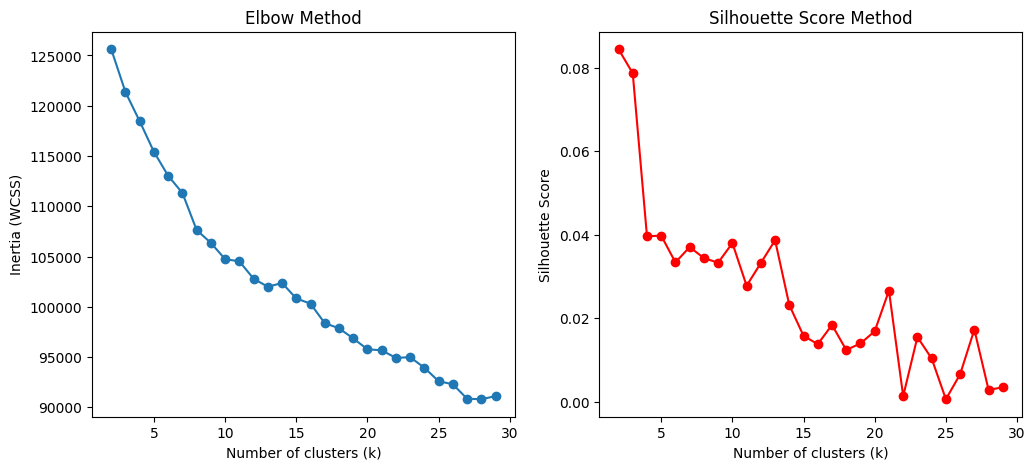

In [15]:
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

inertia = []
silhouette_scores = []
K_range = range(2, 30)  # Testing clusters from 2 to 14

for k in tqdm(K_range):

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker="o", color="r")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")
plt.show()

In [16]:
for optimal_k in tqdm(
    range(2, 100)
):  # Replace with the best value from the elbow or silhouette method
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_merged["cluster"] = kmeans.fit_predict(X_scaled)

    # Check the distribution of is_alz values within each cluster
    cluster_summary = (
        df_merged.groupby("cluster")["is_alz"].value_counts().unstack(fill_value=0)
    )
    # print(cluster_summary)

    # Find clusters that contain only is_alz = 1
    exclusive_clusters = cluster_summary[cluster_summary[0] == 0].index.tolist()

    if exclusive_clusters:
        print(f"Clusters containing only is_alz=1: {exclusive_clusters}")
        print("Optimal k:", optimal_k)
        break
    else:
        continue
        print("No clusters contain only is_alz=1")

  0%|          | 0/98 [00:00<?, ?it/s]

Clusters containing only is_alz=1: [6]
Optimal k: 17


In [17]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_merged["cluster"] = kmeans.fit_predict(X_scaled)

In [18]:
df_merged[df_merged["is_alz"] == 1].shape, len(
    df_merged[df_merged["is_alz"] == 1]
) / len(df_merged)

((23, 532), 0.09236947791164658)

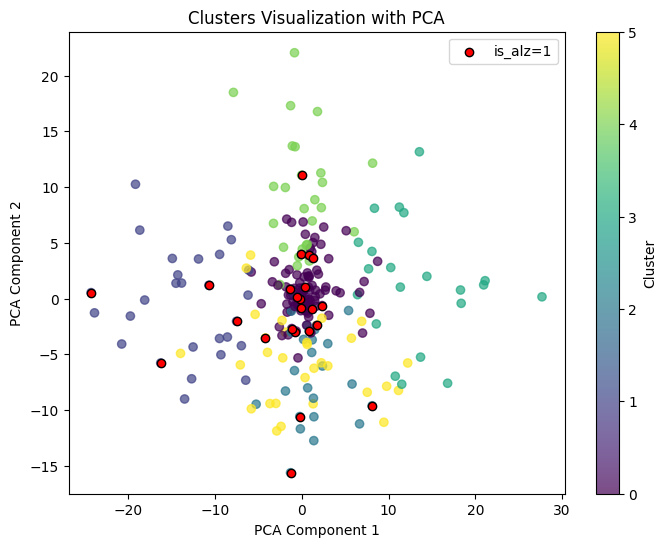

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=df_merged["cluster"], cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters Visualization with PCA")

# Highlight points with is_alz=1
alz_points = df_merged[numeric_cols][df_merged["is_alz"] == 1]
plt.scatter(
    pca.transform(scaler.transform(alz_points[numeric_cols]))[:, 0],
    pca.transform(scaler.transform(alz_points[numeric_cols]))[:, 1],
    color="red",
    label="is_alz=1",
    edgecolors="black",
)

plt.legend()
plt.show()

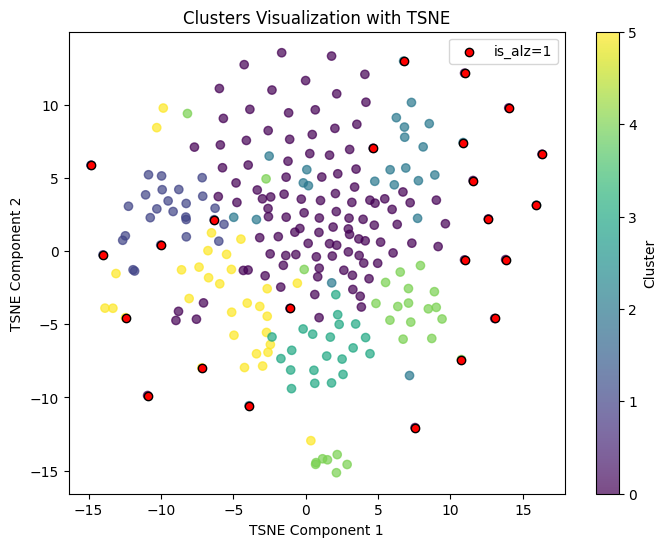

In [ ]:
from sklearn.manifold import TSNE

# Re-run t-SNE with both the main dataset and alz_points
full_data = np.vstack([X_scaled, scaler.transform(alz_points[numeric_cols])])

tsne = TSNE(n_components=2, random_state=42)
X_tsne_full = tsne.fit_transform(full_data)

# Split back the transformed points
X_tsne = X_tsne_full[: len(X_scaled)]
X_tsne_alz = X_tsne_full[len(X_scaled) :]

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=df_merged["cluster"], cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("Clusters Visualization with TSNE")

# Highlight points with is_alz=1
plt.scatter(
    X_tsne_alz[:, 0],
    X_tsne_alz[:, 1],
    color="red",
    label="is_alz=1",
    edgecolors="black",
)

plt.legend()
plt.show()

## Попробуем убрать ненужные столбцы через feature importance

Selected features: ['wm_lh_cuneus', 'wm_lh_entorhinal', 'wm_lh_inferiorparietal', 'wm_lh_isthmuscingulate', 'wm_lh_lateraloccipital', 'wm_lh_lateralorbitofrontal', 'wm_lh_lingual', 'wm_lh_medialorbitofrontal', 'wm_lh_middletemporal', 'wm_lh_parahippocampal', 'wm_lh_parsorbitalis', 'wm_lh_parstriangularis', 'wm_lh_pericalcarine', 'wm_lh_postcentral', 'wm_lh_posteriorcingulate', 'wm_lh_precuneus', 'wm_lh_superiorfrontal', 'wm_lh_superiortemporal', 'wm_lh_supramarginal', 'wm_lh_frontalpole', 'wm_lh_insula', 'wm_rh_caudalanteriorcingulate', 'wm_rh_caudalmiddlefrontal', 'wm_rh_cuneus', 'wm_rh_fusiform', 'wm_rh_lateraloccipital', 'wm_rh_lateralorbitofrontal', 'wm_rh_lingual', 'wm_rh_medialorbitofrontal', 'wm_rh_middletemporal', 'wm_rh_parsopercularis', 'wm_rh_postcentral', 'wm_rh_posteriorcingulate', 'wm_rh_precuneus', 'wm_rh_superiortemporal', 'wm_rh_supramarginal', 'wm_rh_frontalpole', 'Left_UnsegmentedWhiteMatter', 'Left_Lateral_Ventricle', 'Left_Inf_Lat_Vent', 'Left_Cerebellum_White_Matt

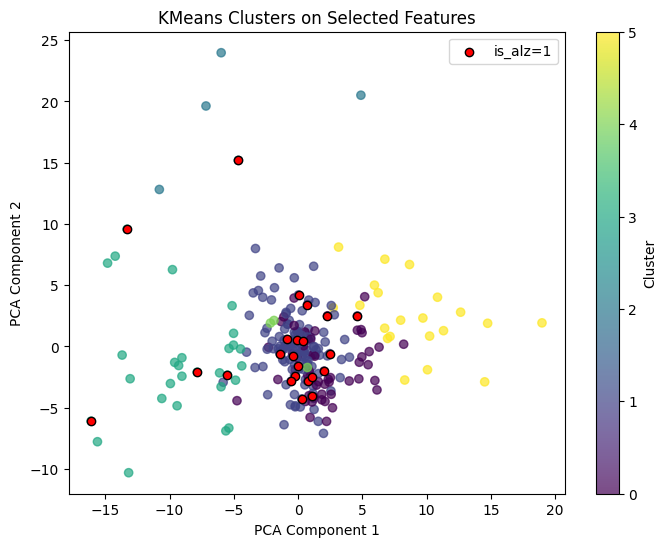

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume df is your DataFrame with 531 columns, including "is_alz"
# and that other columns are potential predictors.

# Separate predictors and target
X = df_merged.drop(columns=["is_alz", "patient_id"])
y = df_merged["is_alz"]

# --- Step 1: Feature Selection using RandomForest ---

# Train a Random Forest classifier to compute feature importances
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Use feature importances to select top features
# Here we select features with importance above the median importance.
selector = SelectFromModel(rf, threshold="median", prefit=True)
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())

# Create a new DataFrame with the selected features
X_selected = df_merged[selected_features]

# Standardize the selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# --- Step 2: Clustering with KMeans ---
# You can experiment with different numbers of clusters.
# For example, you might try a range and inspect the clusters.
optimal_k = 6  # This is an example value; use methods like the elbow or silhouette method to decide.

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_merged["cluster"] = kmeans.fit_predict(X_scaled)

# --- Step 3: Validate Clusters for "Alzheimer-only" groups ---
# Check the distribution of is_alz values in each cluster
cluster_summary = (
    df_merged.groupby("cluster")["is_alz"].value_counts().unstack(fill_value=0)
)
print("Cluster summary:")
print(cluster_summary)

# Identify clusters that contain only is_alz = 1 rows (i.e., no zeros)
alz_exclusive_clusters = cluster_summary[cluster_summary[0] == 0].index.tolist()
if alz_exclusive_clusters:
    print(f"Clusters exclusively containing is_alz=1 rows: {alz_exclusive_clusters}")
else:
    print(
        "No clusters exclusively contain is_alz=1 rows. Consider adjusting your feature selection."
    )

# Optionally, visualize clusters using PCA for 2D plotting
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=df_merged["cluster"], cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clusters on Selected Features")

# Optionally, highlight is_alz=1 rows
alz_points = df_merged[df_merged["is_alz"] == 1]
plt.scatter(
    pca.transform(scaler.transform(X_selected.loc[alz_points.index]))[:, 0],
    pca.transform(scaler.transform(X_selected.loc[alz_points.index]))[:, 1],
    color="red",
    label="is_alz=1",
    edgecolors="black",
)
plt.legend()
plt.show()

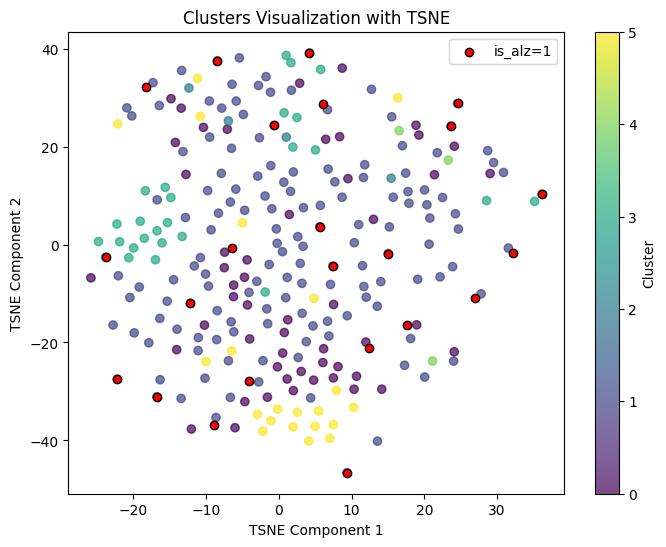

In [ ]:
from sklearn.manifold import TSNE

# Re-run t-SNE with both the main dataset and alz_points
alz_points = df_merged[df_merged["is_alz"] == 1]
full_data = np.vstack([X_selected, X_selected.loc[alz_points.index]])

tsne = TSNE(n_components=2, random_state=42)
X_tsne_full = tsne.fit_transform(full_data)

# Split back the transformed points
X_tsne = X_tsne_full[: len(X_selected)]
X_tsne_alz = X_tsne_full[len(X_selected) :]

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=df_merged["cluster"], cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("Clusters Visualization with TSNE")

# Highlight points with is_alz=1
plt.scatter(
    X_tsne_alz[:, 0],
    X_tsne_alz[:, 1],
    color="red",
    label="is_alz=1",
    edgecolors="black",
)

plt.legend()
plt.show()

Точки с альцгеймером всё еще далеко, попробуем убрать столбцы другим способом

## Попробуем убрать ненужные столбцы через корреляцию

30 столбцов значимы для определения альцгеймера


<ipython-input-23-07c8d9d3469c>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_features, x=correlation_with_alz[top_features], palette="coolwarm")


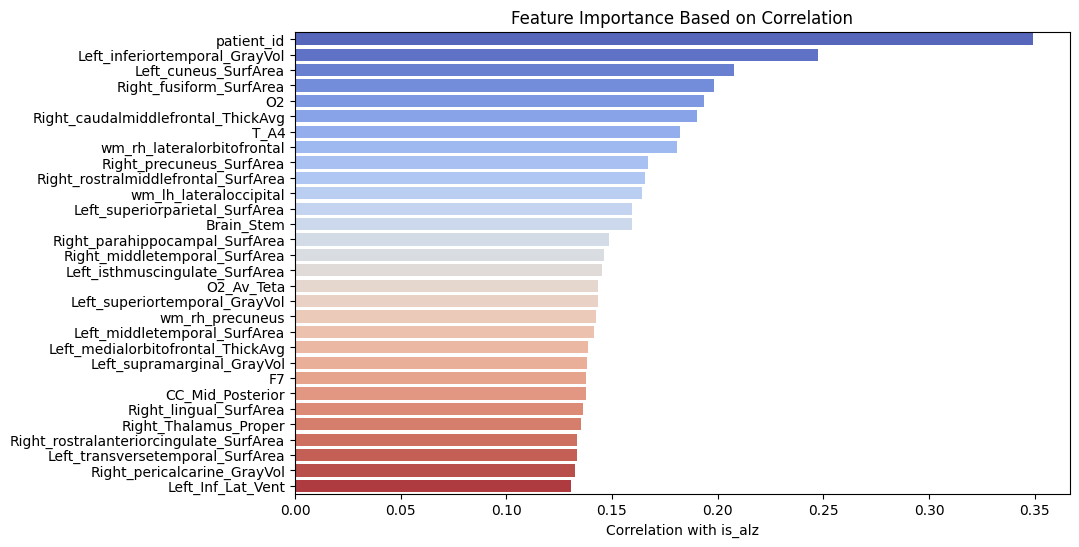

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = df_merged.corr()

# Get correlations with is_alz column
correlation_with_alz = (
    correlation_matrix["is_alz"].drop("is_alz").abs().sort_values(ascending=False)
)

# Select top N most correlated features
top_features = correlation_with_alz[
    correlation_with_alz > 0.13
].index.tolist()  # Adjust threshold as needed

print(len(top_features), "столбцов значимы для определения альцгеймера")

# Plot correlations
plt.figure(figsize=(10, 6))
sns.barplot(y=top_features, x=correlation_with_alz[top_features], palette="coolwarm")
plt.xlabel("Correlation with is_alz")
plt.title("Feature Importance Based on Correlation")
plt.show()

In [24]:
# Drop non-numeric columns except "is_alz"
numeric_cols = (
    df_merged[top_features + ["is_alz"]]
    .select_dtypes(include=[np.number])
    .columns.tolist()
)
numeric_cols.remove("patient_id")
numeric_cols.remove("is_alz")  # Remove is_alz from features for clustering

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged[numeric_cols])

In [25]:
optimal_k = 10  # This is an example value; use methods like the elbow or silhouette method to decide.

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_merged["cluster"] = kmeans.fit_predict(X_scaled)

# --- Step 3: Validate Clusters for "Alzheimer-only" groups ---
# Check the distribution of is_alz values in each cluster
cluster_summary = (
    df_merged.groupby("cluster")["is_alz"].value_counts().unstack(fill_value=0)
)
print("Cluster summary:")
print(cluster_summary)

# Identify clusters that contain only is_alz = 1 rows (i.e., no zeros)
alz_exclusive_clusters = cluster_summary[cluster_summary[0] == 0].index.tolist()
if alz_exclusive_clusters:
    print(f"Clusters exclusively containing is_alz=1 rows: {alz_exclusive_clusters}")
else:
    print(
        "No clusters exclusively contain is_alz=1 rows. Consider adjusting your feature selection."
    )

Cluster summary:
is_alz    0  1
cluster       
0        27  2
1        40  1
2        18  0
3        33  2
4        16  4
5         1  1
6        49  0
7        16  0
8        14  7
9        12  6
No clusters exclusively contain is_alz=1 rows. Consider adjusting your feature selection.


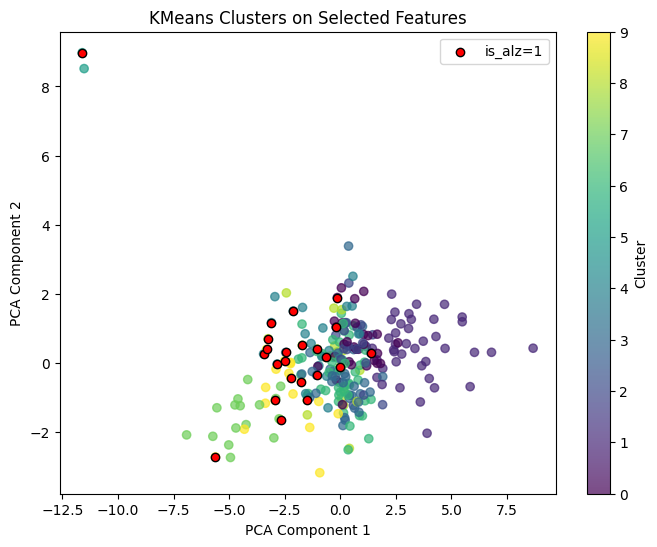

In [26]:
# Optionally, visualize clusters using PCA for 2D plotting
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=df_merged["cluster"], cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clusters on Selected Features")

# Optionally, highlight is_alz=1 rows
alz_points = df_merged[df_merged["is_alz"] == 1]
plt.scatter(
    pca.transform(scaler.transform(alz_points[numeric_cols]))[:, 0],
    pca.transform(scaler.transform(alz_points[numeric_cols]))[:, 1],
    color="red",
    label="is_alz=1",
    edgecolors="black",
)
plt.legend()
plt.show()

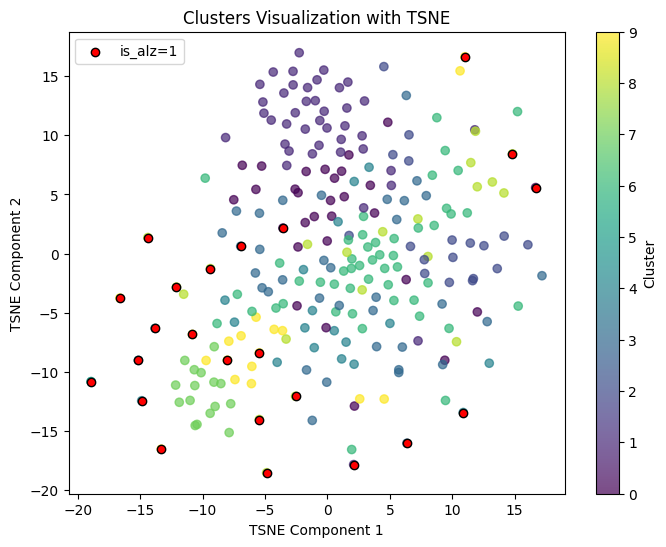

In [ ]:
from sklearn.manifold import TSNE

# Re-run t-SNE with both the main dataset and alz_points
full_data = np.vstack([X_scaled, scaler.transform(alz_points[numeric_cols])])

tsne = TSNE(n_components=2, random_state=42)
X_tsne_full = tsne.fit_transform(full_data)

# Split back the transformed points
X_tsne = X_tsne_full[: len(X_scaled)]
X_tsne_alz = X_tsne_full[len(X_scaled) :]

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=df_merged["cluster"], cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("Clusters Visualization with TSNE")

# Highlight points with is_alz=1
plt.scatter(
    X_tsne_alz[:, 0],
    X_tsne_alz[:, 1],
    color="red",
    label="is_alz=1",
    edgecolors="black",
)

plt.legend()
plt.show()

## Изменение is_alz для кластеров с альцгеймером

In [ ]:
cluster_summary = (
    df_merged.groupby("cluster")["is_alz"].value_counts().unstack(fill_value=0)
)
print("Cluster summary:")
print(cluster_summary)

Cluster summary:
is_alz    0  1
cluster       
0        27  2
1        40  1
2        18  0
3        33  2
4        16  4
5         1  1
6        49  0
7        16  0
8        14  7
9        12  6


In [29]:
df_gnn = pd.DataFrame(X_scaled, columns=numeric_cols)
df_gnn["patient_id"] = df_merged["patient_id"].copy()
df_gnn["is_alz"] = df_merged["is_alz"].copy()
df_gnn["cluster"] = df_merged["cluster"].copy()

df_gnn.head()

,Left_inferiortemporal_GrayVol,Left_cuneus_SurfArea,Right_fusiform_SurfArea,O2,Right_caudalmiddlefrontal_ThickAvg,T_A4,wm_rh_lateralorbitofrontal,Right_precuneus_SurfArea,Right_rostralmiddlefrontal_SurfArea,wm_lh_lateraloccipital,...,CC_Mid_Posterior,Right_lingual_SurfArea,Right_Thalamus_Proper,Right_rostralanteriorcingulate_SurfArea,Left_transversetemporal_SurfArea,Right_pericalcarine_GrayVol,Left_Inf_Lat_Vent,patient_id,is_alz,cluster
0,-0.326181,-0.416239,-1.942515,0.419695,-0.090166,0.449173,-0.738956,-0.471211,-1.368429,-0.649745,...,-0.930133,0.844584,-0.309187,0.756617,0.364556,0.141022,0.681685,0,0,9
1,-1.875409,-1.600232,-1.821458,0.117996,-0.541684,-0.686145,0.759343,-0.578556,-1.072357,-1.319731,...,0.446336,-0.701809,-0.810727,0.260187,-0.877500,-2.194135,-0.391400,1,1,3
2,0.255093,1.989151,0.717357,1.245148,0.238552,1.466542,2.145041,-0.196703,-0.573007,1.584080,...,-0.657849,-0.068927,-0.037887,-0.634088,0.453059,2.340157,-1.222362,2,0,2
3,0.336007,-2.420090,-0.643744,0.064513,-0.404614,0.857860,-0.965581,-0.106906,-0.509936,0.964951,...,-1.449806,0.072843,-0.576892,-0.743113,-0.958416,-0.077097,1.281517,3,1,9
4,-0.401313,-0.449260,0.405803,2.208382,-0.270184,-0.593064,-0.293540,1.234114,0.653931,-0.697917,...,-0.897576,-0.150315,-1.817983,-0.347048,-0.301183,-0.356574,1.214970,4,1,8


In [30]:
df_gnn.loc[df_gnn["cluster"] == 4, "is_alz"] = 1
df_gnn.loc[df_gnn["cluster"] == 8, "is_alz"] = 1
df_gnn.loc[df_gnn["cluster"] == 9, "is_alz"] = 1

In [31]:
cluster_summary = (
    df_gnn.groupby("cluster")["is_alz"].value_counts().unstack(fill_value=0)
)
print("Cluster summary:")
print(cluster_summary)

Cluster summary:
is_alz    0   1
cluster        
0        27   2
1        40   1
2        18   0
3        33   2
4         0  20
5         1   1
6        49   0
7        16   0
8         0  21
9         0  18


# GNN

In [32]:
!pip install torch_geometric

In [33]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

torch.manual_seed(42)

In [34]:
# df_gnn = pd.DataFrame(X_scaled, columns=numeric_cols)
# df_gnn["patient_id"] = df_merged["patient_id"].copy()
# df_gnn["is_alz"] = df_merged["is_alz"].copy()
# df_gnn["cluster"] = df_merged["cluster"].copy()

# df_gnn.head()

In [35]:
df_gnn["is_alz"].value_counts()

,count
is_alz,
0,184
1,65


In [ ]:
from sklearn.model_selection import train_test_split

df_gnn_train, df_gnn_test = train_test_split(
    df_gnn, test_size=0.1, shuffle=True, random_state=42, stratify=df_gnn["is_alz"]
)

In [ ]:
# Build adjacency list based on clusters
def get_edge_index(clusters):
    edge_index = []
    for cluster_id in np.unique(clusters):
        indices = np.where(clusters == cluster_id)[0]
        for i in indices:
            for j in indices:
                if i != j:  # Avoid self-loops
                    edge_index.append([i, j])

    # Convert edge list to PyTorch tensor
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index


clusters_train = df_gnn_train["cluster"]
clusters_test = df_gnn_test["cluster"]

edge_index_train = get_edge_index(clusters_train)
edge_index_test = get_edge_index(clusters_test)

In [ ]:
features_scaled_train = df_gnn_train.drop(
    ["patient_id", "cluster", "is_alz"], axis=1
).values

labels_train = df_gnn_train["is_alz"].values


features_scaled_test = df_gnn_test.drop(
    ["patient_id", "cluster", "is_alz"], axis=1
).values

labels_test = df_gnn_test["is_alz"].values


# Convert data to PyTorch Geometric format

x_train = torch.tensor(features_scaled_train, dtype=torch.float)

y_train = torch.tensor(labels_train, dtype=torch.long)


x_test = torch.tensor(features_scaled_test, dtype=torch.float)

y_test = torch.tensor(labels_test, dtype=torch.long)


# Create graph data object

graph_data_train = Data(x=x_train, edge_index=edge_index_train, y=y_train)

graph_data_test = Data(x=x_test, edge_index=edge_index_test, y=y_test)

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(
    in_channels=features_scaled_train.shape[1], hidden_channels=64, out_channels=2
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced", classes=np.unique(labels_train), y=labels_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [113]:
# _, classes_len = np.unique(labels_train, return_counts=True)
# classes_weights = classes_len / len(labels_train)
# class_weights=torch.tensor(class_weights,dtype=torch.float)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


# Train loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data_train.x, graph_data_train.edge_index)
    loss = criterion(out, graph_data_train.y)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        out = model(graph_data_test.x, graph_data_test.edge_index)
        loss_test = criterion(out, graph_data_test.y)

    return loss.item(), loss_test.item()


# Training
train_losses = []
test_losses = []

best_loss = np.inf
count_best_loss_in_row = 0
threshold_best_loss_in_row = 10

for epoch in range(1000):
    loss, loss_test = train()
    train_losses.append(loss)
    test_losses.append(loss_test)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

    if round(loss, 5) < round(best_loss, 5):
        best_loss = loss
        count_best_loss_in_row = 0
    elif threshold_best_loss_in_row < count_best_loss_in_row:
        break
    else:
        count_best_loss_in_row += 1

num_trained_epoch = epoch + 1

Epoch 0, Loss: 0.6291731595993042
Epoch 10, Loss: 0.22556853294372559
Epoch 20, Loss: 0.14934875071048737
Epoch 30, Loss: 0.13026611506938934
Epoch 40, Loss: 0.1262262463569641
Epoch 50, Loss: 0.1249258890748024
Epoch 60, Loss: 0.12431784719228745
Epoch 70, Loss: 0.12401825934648514
Epoch 80, Loss: 0.12384458631277084
Epoch 90, Loss: 0.12373179197311401
Epoch 100, Loss: 0.12365134805440903
Epoch 110, Loss: 0.12359122931957245
Epoch 120, Loss: 0.12354324012994766
Epoch 130, Loss: 0.1235039010643959
Epoch 140, Loss: 0.12347041815519333
Epoch 150, Loss: 0.12344203144311905
Epoch 160, Loss: 0.12341750413179398
Epoch 170, Loss: 0.12339603900909424
Epoch 180, Loss: 0.12337616831064224
Epoch 190, Loss: 0.12335896492004395
Epoch 200, Loss: 0.12334362417459488
Epoch 210, Loss: 0.12333033233880997
Epoch 220, Loss: 0.1233188584446907
Epoch 230, Loss: 0.1233087033033371
Epoch 240, Loss: 0.12329966574907303
Epoch 250, Loss: 0.12329147011041641
Epoch 260, Loss: 0.12328331917524338
Epoch 270, Loss: 0

Text(0, 0.5, 'loss')

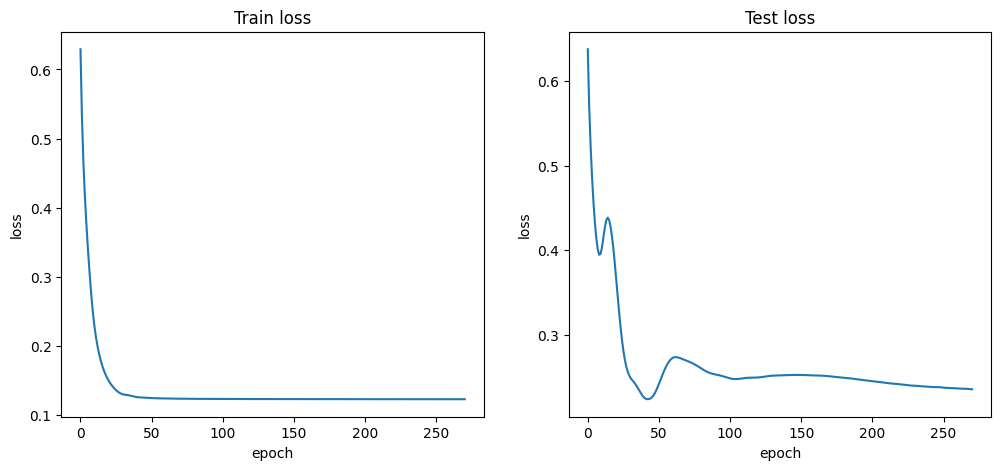

In [115]:
# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_trained_epoch), train_losses)
plt.title("Train loss")
plt.xlabel("epoch")
plt.ylabel("loss")

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(num_trained_epoch), test_losses)
plt.title("Test loss")
plt.xlabel("epoch")
plt.ylabel("loss")

In [116]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
model.eval()
with torch.no_grad():
    predictions_train = model(graph_data_train.x, graph_data_train.edge_index).argmax(
        dim=1
    )
    predictions_test = model(graph_data_test.x, graph_data_test.edge_index).argmax(
        dim=1
    )

    accuracy_train = accuracy_score(labels_train, predictions_train)
    precision_train = recall_score(labels_train, predictions_train)
    recall_train = precision_score(labels_train, predictions_train)
    f1_score_train = f1_score(labels_train, predictions_train.detach())

    accuracy_test = accuracy_score(labels_test, predictions_test)
    precision_test = recall_score(labels_test, predictions_test)
    recall_test = precision_score(labels_test, predictions_test)
    f1_score_test = f1_score(labels_test, predictions_test)

    print(f"Accuracy_train: {accuracy_train:.4f}")
    print(f"precision_train: {precision_train:.4f}")
    print(f"recall_train: {recall_train:.4f}")
    print(f"f1_score_train: {f1_score_train:.4f}")

    print(f"\nAccuracy_test: {accuracy_test:.4f}")
    print(f"precision_test: {precision_test:.4f}")
    print(f"recall_test: {recall_test:.4f}")
    print(f"f1_score_test: {f1_score_test:.4f}")

Accuracy_train: 0.9777
precision_train: 0.9138
recall_train: 1.0000
f1_score_train: 0.9550

Accuracy_test: 0.9600
precision_test: 0.8571
recall_test: 1.0000
f1_score_test: 0.9231
